# Practical Session : Playing Stochastic Multi-Armed Bandit Games

Code inspired by the [Pyma bandit library](https://www.di.ens.fr/~cappe/Code/PymaBandits/) by O. Cappé and A. Garivier and the [SMPyBandit library](https://github.com/SMPyBandits/SMPyBandits) of Lilian Besson.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import time

# Bandit specific functions and classes 
import Arms as arm
from StochasticBandit import *
from BanditTools import * 
import BanditBaselines as alg

# I) Understanding the experimental setup with naive bandit strategies


### 1) Creating a bandit environnement

Different arm classes are defined in `Arms.py` (you are welcome to add more!). To define a multi-armed bandit (a `MAB` object), you need to input a list of such arms. Some functions in `StochasticBandits.py` also define MAB objects directly. 


In [6]:
nbArms = 3
bandit1 = MAB([arm.Bernoulli(0.2), arm.Gaussian(3, 1), arm.TruncatedExponential(2, 1)])
bandit2 = BernoulliBandit([0.3, 0.4, 0.5]) # directly creates a Bernoulli bandit from a vector of means

print("The means of bandit instance 1 are", bandit1.means)
print("The means of bandit instance 2 are", bandit2.means)



The means of bandit instance 1 are [0.2, 3, 0.43233235838169365]
The means of bandit instance 2 are [0.3, 0.4, 0.5]


### 2) Executing a simple bandit strategy

The function given below executes one bandit algorithm on one MAB instance. 

In [5]:
def OneBanditOneLearnerOneRun(bandit, learner, timeHorizon):
    """
    Run a bandit strategy (learner) on a MAB instance (bandit) for (timeHorizon) time steps
    output : sequence of arms chosen, sequence of rewards obtained
    """
    selections = []
    rewards = []
    learner.clear() # reset previous history
    for t in range(timeHorizon):
        arm = learner.chooseArmToPlay()
        reward = bandit.generateReward(arm)
        learner.receiveReward(arm, reward)
        # Update statistics
        selections.append(arm)
        rewards.append(reward)
    return selections, rewards
    
def CumulativeRegret(bandit,selections):
    """Compute the pseudo-regret associated to a sequence of arm selections"""
    return np.cumsum(max(bandit.means)*np.ones(len(selections)) - np.array(bandit.means)[selections])

For the moment, we implemented two naive bandit strategies : the greedy strategy (or Follow-the-Leader, `FTL`) and a strategy that explores arms uniformly at random (`UniformExploration`). Such strategies (as the one you will implement) are defined as objects in `BanditsAlgorithms.py`. Below we run `FTL` on one of the bandit instances defined above, and visualize its behavior.

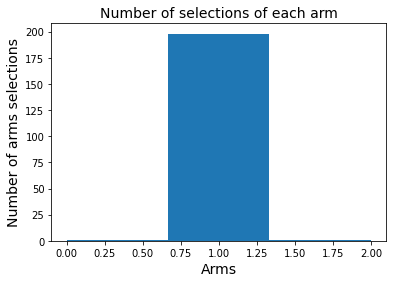

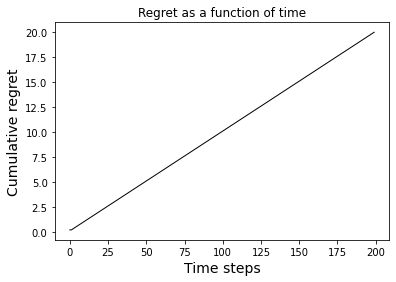

In [6]:
timeHorizon = 200
bandit = bandit2
learner = alg.FTL(nbArms)

selections, rewards = OneBanditOneLearnerOneRun(bandit, learner, timeHorizon)
regret = CumulativeRegret(bandit, selections)

# Visualize results (on one run) 

# Histogram of the number of arms selections
plt.clf()
plt.xlabel("Arms", fontsize=14)
plt.ylabel("Number of arms selections", fontsize=14)
plt.hist(selections, max(selections) + 1)
plt.title("Number of selections of each arm", fontsize=14)
# plt.savefig('./Figure/test'+ learner.name() + '.pdf')

# Cumulative regret as a function of time
plt.figure(2)
plt.clf()
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(timeHorizon), regret, 'black', linewidth=1)
 

### 3) Comparing two (bad) learners on one run

We now compare pure exploration and pure exploitation on a single run. If you run this code multiple time, you will have very different results.

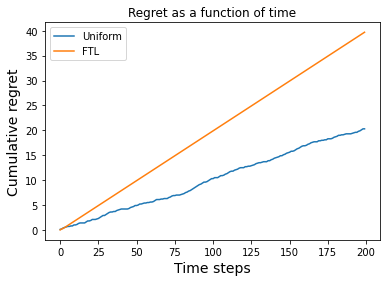

In [7]:
learner1 = alg.UniformExploration(nbArms)
learner2 = alg.FTL(nbArms)

# Run the two learners
selections, rewards = OneBanditOneLearnerOneRun(bandit, learner1, timeHorizon)
regret1 = CumulativeRegret(bandit, selections)
selections, rewards = OneBanditOneLearnerOneRun(bandit, learner2, timeHorizon)
regret2 = CumulativeRegret(bandit, selections)

# Compare their regret
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(0, timeHorizon), regret1,label=learner1.name())
plt.plot(range(0, timeHorizon), regret2,label=learner2.name())
plt.legend()

### 4) Comparison averaged over multiple runs

The regret is defined as an **expectation**, so we need several runs to **estimate** its value. We can also take a look at the distribution of the pseudo-regret. The function below gathers results accross multiple runs.

In [8]:
def OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon, N_exp, tsave=[]):
    if (len(tsave) == 0):
        tsave = np.arange(timeHorizon)
    savedTimes = len(tsave)
    Regret = np.zeros((N_exp, savedTimes)) # Store the regret values on different runs
    for n in range(N_exp):
        np.random.seed()
        selections, rewards = OneBanditOneLearnerOneRun(bandit, learner, timeHorizon)
        regret_one_run = CumulativeRegret(bandit, selections)
        Regret[n, :] = np.array(regret_one_run)[tsave] # Store a sub-sampling of the cumulative regret
    return Regret

#### a) For one algorithm (FTL)

In [9]:
N_exp = 200
timeHorizon = 200
tsave = np.arange(1, timeHorizon, 10)
Regret = OneBanditOneLearnerMultipleRuns(bandit, learner2, timeHorizon, N_exp, tsave)

One can start by displaying the mean regret and some quantiles. 

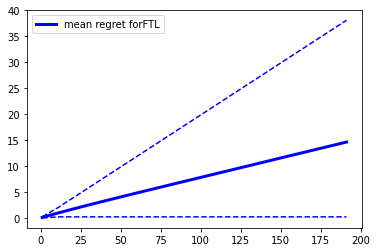

In [10]:
meanRegret = np.mean(Regret, 0)
upperQuantile = np.quantile(Regret, 0.95, 0) # requires numpy 1.15
lowerQuantile = np.quantile(Regret, 0.05, 0)

plt.clf()
plt.plot(tsave, meanRegret, linewidth=3.0, color="b", label="mean regret for"+learner2.name())
plt.plot(tsave, upperQuantile, linestyle="dashed", color="b")
plt.plot(tsave, lowerQuantile, linestyle="dashed", color="b")
plt.legend()


To highlight the variability of the regret, one can also look at the histogram of the value of $R_T$.

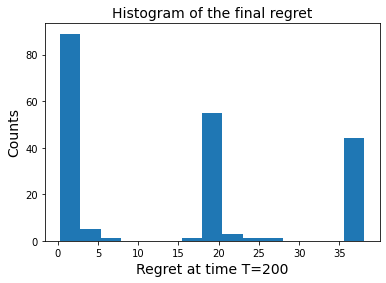

In [11]:
FinalRegret = Regret[:, len(tsave)-1]
plt.clf()
plt.xlabel("Regret at time T="+str(timeHorizon), fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.hist(FinalRegret, 15)
plt.title("Histogram of the final regret", fontsize=14)
plt.show()


#### b) FTL versus Uniform

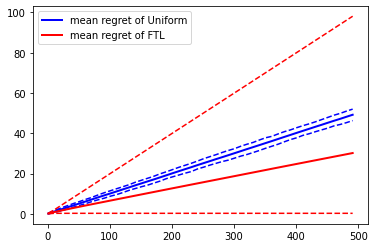

In [12]:
N_exp = 200
timeHorizon = 500
tsave = np.arange(1, timeHorizon, 10)

Regret1 = OneBanditOneLearnerMultipleRuns(bandit, learner1, timeHorizon, N_exp, tsave)
Regret2 = OneBanditOneLearnerMultipleRuns(bandit, learner2, timeHorizon, N_exp, tsave)

plt.clf()
plt.plot(tsave, np.mean(Regret1, 0), linewidth=2.0, color="b", label="mean regret of "+learner1.name())
plt.plot(tsave, np.quantile(Regret1, 0.95, 0), tsave, np.quantile(Regret1,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(Regret2, 0), linewidth=2.0, color="r", label="mean regret of "+learner2.name())
plt.plot(tsave, np.quantile(Regret2, 0.95, 0), tsave, np.quantile(Regret2,0.05,0), linestyle="dashed", color="r")
plt.legend()
plt.show()

As you can see, both algorithms have **linear regret**, although the pseudo-regret of FTL has a much higher variance. You are now ready to try smarter algorithms!

# II) The UCB1 algorithm

The UCB1 algorithm is proposed by [Auer et al](https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf) for bandit instances with bounded rewards (in $[0,1]$ to fix the ideas). One can extend it to depend on some parameter $\alpha$: 

$$A_{t} = \underset{a}{\text{argmax}} \left[\hat{\mu}_a(t-1) + \sqrt{\frac{\alpha \log(t)}{N_a(t-1)}}\right],$$
where $\hat{\mu}_a(t)$ is the empirical mean of arm $a$ after $t$ rounds and $N_a(t)$ is the number of selections of arm $a$ till that time. 

UCB1 was originally proposed with $\alpha = 2$. Its analysis was later refined to allow for $\alpha > 1/2$ (see [here](http://sbubeck.com/Bubeckthesis.pdf) or [here](https://hal.archives-ouvertes.fr/hal-00738209/file/klucb.pdf)).

* Implement UCB($\alpha$).


In [13]:
class UCB:
    """UCB1 with parameter alpha"""
    def __init__(self, nbArms, alpha=1/2):
        self.nbArms = nbArms
        self.alpha = alpha
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            index = self.cumRewards/self.nbDraws + np.sqrt(self.alpha*log(self.t)/self.nbDraws)
            return randmax(index) 

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward

    def name(self):
        return "UCB"

* Pick a bounded bandit instance of your choice, and run UCB. Is the regret still linear?

The arms means are [0.43233235838169365, 0.3, 0.27708646187933755]


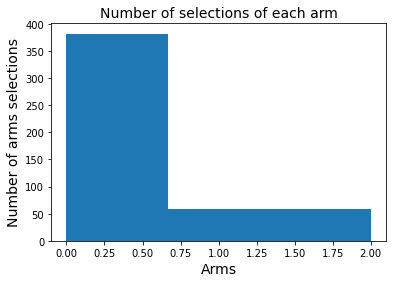

In [14]:
bandit = MAB([arm.TruncatedExponential(2, 1), arm.Bernoulli(0.3), arm.TruncatedExponential(3.5, 1)])
print("The arms means are", bandit.means)

# One run
learner = UCB(3, 0.5)
selections,rewards = OneBanditOneLearnerOneRun(bandit, learner, 500)

plt.xlabel("Arms", fontsize=14)
plt.ylabel("Number of arms selections", fontsize=14)
plt.hist(selections, max(selections)+1)
plt.title("Number of selections of each arm", fontsize=14)
plt.show()

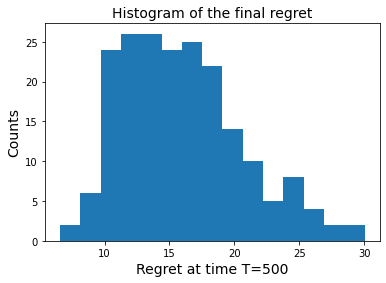

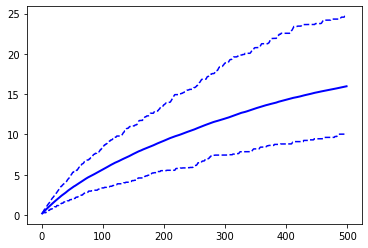

In [15]:
# Multiple runs
tsave = np.arange(1, timeHorizon, 1)
Regret = OneBanditOneLearnerMultipleRuns(bandit, UCB(3), 500, 200, tsave)

FinalRegret = Regret[:, len(tsave)-1]
plt.xlabel("Regret at time T="+str(timeHorizon), fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.hist(FinalRegret, 15)
plt.title("Histogram of the final regret", fontsize=14)

plt.figure()
plt.plot(tsave, np.mean(Regret,0), linewidth=2.0, color="b", label="Mean regret of UCB")
plt.plot(tsave, np.quantile(Regret, 0.95, 0), tsave, np.quantile(Regret,0.05,0), linestyle="dashed", color="b")
plt.show()

This looks much safer than FTL! The regret of UCB is logarithmic.

#### Influence of the parameter $\alpha$

* On a fixed bandit problem, run UCB with several values for the parameter $\alpha$, and find the best value for this problem. 

In [16]:
bandit = MAB([arm.Bernoulli(0.3), arm.Bernoulli(0.6), arm.Bernoulli(0.8), arm.TruncatedExponential(0.7, 1)])
print("The means in this bounded instance are", bandit.means)

The means in this bounded instance are [0.3, 0.6, 0.8, 0.7191638517265578]


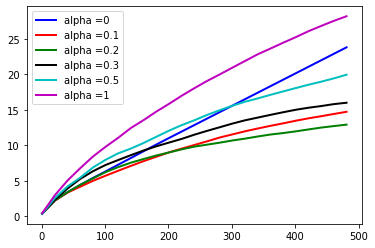

The best alpha on this instance is alpha = 0.2


In [17]:
alphas = [0, 0.1, 0.2, 0.3, 0.5, 1]
algos = [UCB(4, alpha) for alpha in alphas]
colors = ["b", "r", "g", "k", "c", "m"]

nbAlgos = len(alphas)

N_exp = 200
timeHorizon = 500
tsave = np.arange(1, timeHorizon, 20)

regFinal = np.zeros(nbAlgos)

for i in range(nbAlgos):
    alpha = alphas[i]
    learner = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon, N_exp, tsave)
    plt.plot(tsave, np.mean(Regret,0), linewidth=2.0, color=colors[i], label="alpha ="+str(alpha))
    # plt.plot(tsave, np.quantile(Regret,0.95,0), tsave, np.quantile(Regret,0.05,0), linestyle="dashed", color=colors[i])
    regFinal[i] = np.mean(Regret, 0)[len(tsave)-1]
plt.legend()
plt.show()

print("The best alpha on this instance is alpha =", alphas[np.argmin(regFinal)])

#### Influence of the minimal gap (regret on different instances)

The function `RandomBernoulliBandit()` in `Stochastic_Bandits.py` allows to generate random Bernoulli bandit instance in which the gap between the best and second best arm has a certain value. 

* Visualize the regret for several instances with different values of the minimal gap $\Delta$, and comment on its influence on the regret.

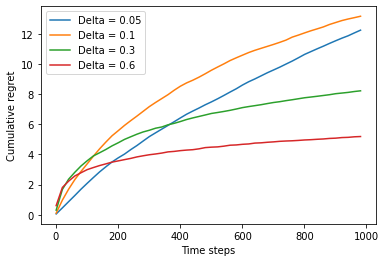

In [18]:
nbArms = 2
timeHorizon = 1000
nExp = 100

tsave = np.arange(1, timeHorizon, 20)
learner = UCB(nbArms)

bandit1 = RandomBernoulliBandit(0.05, nbArms)
Regret1 = OneBanditOneLearnerMultipleRuns(bandit1, learner, timeHorizon, 200, tsave)

bandit2 = RandomBernoulliBandit(0.1, nbArms)
Regret2 = OneBanditOneLearnerMultipleRuns(bandit2, learner, timeHorizon, 200, tsave)

bandit3 = RandomBernoulliBandit(0.3, nbArms)
Regret3 = OneBanditOneLearnerMultipleRuns(bandit3, learner, timeHorizon, 200, tsave)

bandit4 = RandomBernoulliBandit(0.6, nbArms)
Regret4 = OneBanditOneLearnerMultipleRuns(bandit4, learner, timeHorizon, 200, tsave)


# Generate a name and plot the data
plt.plot(tsave, np.mean(Regret1, axis=0), label='Delta = 0.05')
plt.plot(tsave, np.mean(Regret2, axis=0), label='Delta = 0.1')
plt.plot(tsave, np.mean(Regret3, axis=0), label='Delta = 0.3')
plt.plot(tsave, np.mean(Regret4, axis=0), label='Delta = 0.6')

plt.xlabel("Time steps", fontsize=10)
plt.ylabel("Cumulative regret", fontsize=10)
plt.legend()
plt.show()

On a MAB instance with bounded rewards, UCB (with parameter alpha = 1/2) is known to satisfy 

$$ \mathcal{R}_T \simeq  \sum_{a,\Delta_{a} > 0} \frac{\log(T)}{2\Delta_{a}} \simeq \frac{K-1}{\Delta}\log(T)$$

where $\Delta$ is the minimal gap. In the above experiment, we indeed observe that the regret usually increases when $\Delta$ gets smaller. But we will later be more precise on what really influences the regret rate of a bandit algorithm (the gap between the best and second best arm is actually not enough to characterize the complexity!). 

# III) Tweaking the UCB algorithm

Applying the UCB algorithm to bounded rewards, the following tweaks are quite natural. First, the rewards are in $[0,1]$, but the UCB values may be outside this interval, so in practice one may want to "clip" them to be in the interval $[0,1]$. Then, when breaking ties, instead of choosing at random, one may do it in favor of the least selected arm instead of uniformly at random. This suggests the following modification of UCB($\alpha$):

$$A_{t+1} = \text{argmin}_{a} \left\{N_a(t) : a \in \text{argmax}_{a} \min\left[\mathrm{UCB}_a(t) , 1\right] \right\}$$

* Implement this simple modification of UCB. 

In [19]:
class UCB_Tweak:
    """UCB1 with parameter alpha, taking the minimum between the UCB and one and breaking ties in favor of the least drawn arm"""
    def __init__(self, nbArms, alpha=1/2):
        self.nbArms = nbArms
        self.alpha = alpha
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            index = np.minimum(self.cumRewards/self.nbDraws + np.sqrt(self.alpha*log(self.t)/self.nbDraws), np.ones(self.nbArms))
            maxVal = max(index)
            candidates = [i for i in range(self.nbArms) if index[i]==maxVal]
            to_draw = randmax(-self.nbDraws[candidates])
            return candidates[to_draw]

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward

    def name(self):
        return "UCB-Tweaked"

#### Different regret guarantees

The guarantees of UCB1 are given in terms of expected regret. Some authors have proposed a variant of the algorithm with high probability guarantees (see, e.g., Section 6 of [this paper](https://papers.nips.cc/paper/4417-improved-algorithms-for-linear-stochastic-bandits.pdf)). For some small value of the parameter $\delta$ (e.g. $\delta = 0.05$), you can try the alternative UCB algorithm, based on the index 

$$\widetilde{\mathrm{UCB}}_a(t) = \hat{\mu}_a(t) + \sqrt{\frac{1+\frac{1}{N_a(t)}}{2N_a(t)}\ln\left(\frac{K\sqrt{N_a(t) + 1}}{\delta}\right)}$$

* Implement this "high-probability" UCB and compare it with the previous algorithms

In [20]:
class UCB_Laplace:
    """UCB using other types of deviation inequalities"""
    def __init__(self, nbArms, delta=0.01):
        self.nbArms = nbArms
        self.delta = delta
        self.clear()
        self.indices = np.ones(self.nbArms)

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.indices=np.ones(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        maxVal = max(self.indices)
        candidates = [i for i in range(self.nbArms) if self.indices[i]==maxVal]
        to_draw = randmax(-self.nbDraws[candidates])
        return candidates[to_draw]

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward
        n = self.nbDraws[arm]
        self.indices[arm] = min(1, self.cumRewards[arm]/n + sqrt(((1+1/n)/n)*(1+log(self.nbArms*sqrt(n+1)/self.delta))))

    def name(self):
        return "UCB-Laplace"

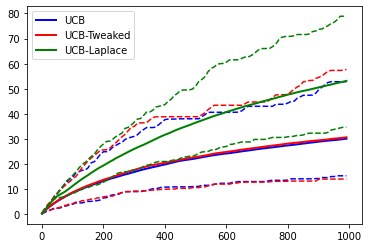

In [21]:
means = [0.1, 0.2, 0.3, 0.4]

bandit = BernoulliBandit(means)
K = len(means)

nExp = 200
timeHorizon = 1000
tsave = np.arange(1, timeHorizon, 10)

algos = [UCB(K), UCB_Tweak(K), UCB_Laplace(K)]
colors = ["b","r","g","c","m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())
    plt.plot(tsave, np.quantile(Regret, 0.99, 0), tsave, np.quantile(Regret, 0.01, 0), linestyle="dashed", color=colors[i])

plt.legend()

UCB-Laplace performs slightly worse. Observe that it has different regret guarantees compared to the other algorithms: something like 
$$\mathbb{P}\left(\forall t\in \mathbb{N}, \mathcal{R}_t \leq  C\sum_{a : \mu_a < \mu_\star}\frac{1}{\Delta_a}\ln\left(\frac{K}{\Delta_a \delta}\right) \right)\geq 1 - \delta.$$
This high probability upper-bound is constant with respect to $T$. However, in expectation, one should control the probability $\delta$ of the unfavorable event on which the regret can be as bad as $T$. Choosing $\delta = 1/T$ would yield (again) to a logarithmic upper bound on the expected regret at time $T$.

# IV) Complexity of a bandit problem 

On a Bernoulli bandit instance, the Lai and Robbins lower bound tells us that the regret is **asymptotically** no smaller than 

$$\left(\sum_{a ,\Delta_a > 0} \frac{\Delta_a}{\mathrm{kl}(\mu_a,\mu_\star)}\right) \log(T),$$
where $\mathrm{kl}(\mu_a,\mu_\star)$ is the KL-divergence between the Bernoulli distribution of parameter $\mu_a$ and the Bernoulli distribution of parameter $\mu_\star$. The constant in front of the $\log(T)$ may be called the **complexity** of the bandit problem.

* Write a function that computes the complexity of a Bernoulli bandit instance

In [22]:
def Complexity(bandit):
    mumax = bandit.means[bandit.bestarm]
    complexity = 0
    for a in range(bandit.nbArms):
        mu = bandit.means[a]
        if (mu != mumax):
            complexity = complexity + (mumax - mu)/klBern(mu,mumax)
    return complexity

* On a Bernoulli bandit instance of your choice, add the theoretical lower bound $t \mapsto C(\nu) \log(t)$ where $C(\nu)$ is the complexity of the bandit problem to the regret curve of UCB. 


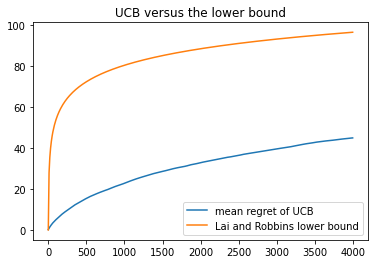

In [23]:
bandit = BernoulliBandit([0.2, 0.35, 0.4])
timeHorizon = 4000
nExp = 200

tsave = np.arange(1, timeHorizon, 10)
LB = Complexity(bandit) * np.log(tsave)

Regret = OneBanditOneLearnerMultipleRuns(bandit, UCB(3), timeHorizon, nExp, tsave)

plt.plot(tsave, np.mean(Regret, axis=0), label='mean regret of UCB')
plt.plot(tsave, LB, label="Lai and Robbins lower bound")
plt.title("UCB versus the lower bound")
plt.legend()


* Is UCB matching the lower bound? You may want to plot $\mathcal{R}_t$ as a function of $\log(t)$ (and look at large horizons) for a better check

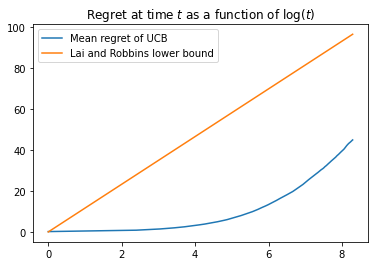

In [24]:
# log scale: check the slope 
plt.figure()
plt.plot(np.log(tsave), np.mean(Regret, axis=0), label='Mean regret of UCB')
plt.plot(np.log(tsave), LB, label="Lai and Robbins lower bound")
plt.title("Regret at time $t$ as a function of $\log(t)$")
plt.legend()

The lower bound is super asymptotic! We see that UCB will eventually have a sub-optimal regret for large horizons... 

# V) From UCB to kl-UCB

In the Bernoulli case, we now investigate an algorithm designed for matching the Lai and Robbins lower bound, that is $\mathrm{kl}$-UCB, proposed by [Cappé et al](https://hal.archives-ouvertes.fr/hal-00738209/file/klucb.pdf). It is also a UCB algorithm, but the upper confidence bound is more sophisticated: 

$$\mathrm{UCB}_a(t) = \max \left\{ q : N_a(t) \mathrm{kl}\left(\hat{\mu}_a(t),q\right) \leq \log(t) + c\log\log(t) \right\},$$
where $\mathrm{kl}(\mu,\mu')$ is the KL-divergence between the distribution with mean $\mu$ and that of mean $\mu'$ in some exponential family and $c$ is some real parameter (often chosen to be zero in practice).

In the Bernoulli case, this is the Bernoulli KL-divergence $\mathrm{kl}(x,y) = x\log(x/y) + (1-x)\log((1-x)/(1-y)).$

Useful KL-divergence functions are already given in `BanditTools.py`.

Here is a visualization of the computation of $\mathrm{UCB}_a(t)$.

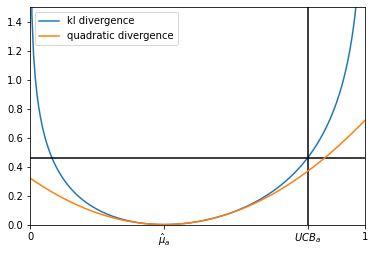

In [25]:
mu_hat = 0.4
log_t_N = np.log(100)/10

# Plot kl-divergence kl(mu_hat, q)
qq = np.linspace(0, 1, 200)
bern_kl_div = [klBern(mu_hat, q) for q in qq]
plt.plot(qq, bern_kl_div, label="kl divergence")
plt.xlim([0, 1])
plt.ylim([0, 1.5])

# Plot kl-UCB = max(q: kl(mu_hat,q) <= log_t/N)
plt.axhline(log_t_N, color="black")
plt.axvline(klucbBern(mu_hat, log_t_N), color="black")
plt.xticks([0, mu_hat, klucbBern(mu_hat, log_t_N), 1], ('0', r'$\hat{\mu}_a$', r'$UCB_a$', '1'))

# Plot quadratic divergence
plt.plot(qq, 2*(qq - mu_hat)**2, label="quadratic divergence")
plt.legend()

* Implement the kl-UCB algorithm. Some help for the computation of the indices can be found in BanditTools.py. You may want to code a generic version of kl-UCB, based on a divergence function to specify.

In [26]:
class klUCB:
    """klUCB (Bernoulli divergence by default)"""
    def __init__(self, nbArms, divergence=klucbBern, c=0):
        self.nbArms = nbArms
        self.divergence = divergence
        self.c = c
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            index = np.zeros(self.nbArms)
            for a in range(self.nbArms):
                index[a] = self.divergence(self.cumRewards[a]/self.nbDraws[a], (log(self.t)+self.c*log(log(self.t)))/self.nbDraws[a])
            return randmax(index)

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward

    def name(self):
        return "kl-UCB"

* Compare the regret of UCB, kl-UCB and the lower bound on at least the following two instances.

The first instance has means very close to 0.5, and $\mathrm{kl}(x,y) \simeq 2(x-y)^2$ is a good approximation in this regime.
Hence we expect UCB and kl-UCB to perform similarly on such an instance. 

On the second instance where the means are very low (a scenario inspired by online advertisement), the choice of algorithm is expected to make a bigger difference. 

In [27]:
banditA = BernoulliBandit([0.45, 0.5, 0.6])  
banditB = BernoulliBandit([0.1, 0.05, 0.02, 0.01])

#### Comparing the algorithm on Bandit A

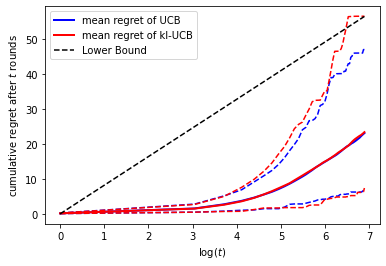

In [28]:
learner1 = UCB(3)
learner2 = klUCB(3)

nExp = 200
timeHorizon = 1000
tsave = np.arange(1, timeHorizon, 20)

Regret1 = OneBanditOneLearnerMultipleRuns(banditA, learner1, timeHorizon, nExp, tsave)
Regret2 = OneBanditOneLearnerMultipleRuns(banditA, learner2, timeHorizon, nExp, tsave)

LBA = Complexity(banditA) * np.log(tsave)

# plot everything (log scale for x axis) 

plt.plot(np.log(tsave), np.mean(Regret1, 0), linewidth=2.0, color="b", label="mean regret of "+learner1.name())
plt.plot(np.log(tsave), np.quantile(Regret1, 0.99, 0), np.log(tsave), np.quantile(Regret1, 0.01, 0), linestyle="dashed", color="b")

plt.plot(np.log(tsave), np.mean(Regret2, 0), linewidth=2.0, color="r", label="mean regret of "+learner2.name())
plt.plot(np.log(tsave), np.quantile(Regret2, 0.99, 0), np.log(tsave), np.quantile(Regret2,0.01,0), linestyle="dashed", color="r")

plt.plot(np.log(tsave), LBA, color="k",linestyle="dashed", label="Lower Bound")

plt.xlabel("$\log(t)$")
plt.ylabel("cumulative regret after $t$ rounds")
plt.legend()

The regret obtained by the two algorithms is quite comparable. 

#### Comparing the algorithms on Bandit B

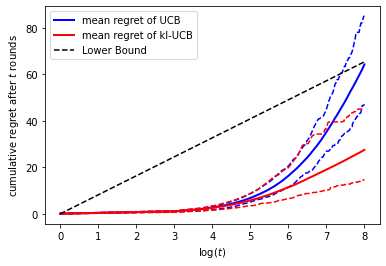

In [29]:
learner1 = UCB(4)
learner2 = klUCB(4)

nExp = 200
timeHorizon = 3000
tsave = np.arange(1, timeHorizon, 20)

Regret1 = OneBanditOneLearnerMultipleRuns(banditB, learner1, timeHorizon, nExp, tsave)
Regret2 = OneBanditOneLearnerMultipleRuns(banditB, learner2, timeHorizon, nExp, tsave)

LBB = Complexity(banditA) * np.log(tsave)

# plot everything (log scale for x axis) 

plt.plot(np.log(tsave), np.mean(Regret1, 0), linewidth=2.0, color="b", label="mean regret of "+learner1.name())
plt.plot(np.log(tsave), np.quantile(Regret1, 0.99, 0), np.log(tsave), np.quantile(Regret1, 0.01, 0), linestyle="dashed", color="b")

plt.plot(np.log(tsave), np.mean(Regret2, 0), linewidth=2.0, color="r", label="mean regret of "+learner2.name())
plt.plot(np.log(tsave), np.quantile(Regret2, 0.99, 0), np.log(tsave), np.quantile(Regret2, 0.01, 0), linestyle="dashed", color="r")

plt.plot(np.log(tsave), LBB, color="k", linestyle="dashed",label="Lower Bound")

plt.xlabel("$\log(t)$")
plt.ylabel("cumulative regret after $t$ rounds")
plt.legend()

#### Beyond Bernoulli Bandits

kl-UCB is also suited for rewards that belong to other one-dimensional exponential family, like Gaussian distributions with known variance, Poisson distributions or Exponential distributions (all the corresponding kl-divergences are given in `BanditTools.py`).

* Try kl-UCB for a different family of distributions

Text(0.5, 1.0, 'Regret of kl-UCB for Exponential rewards')

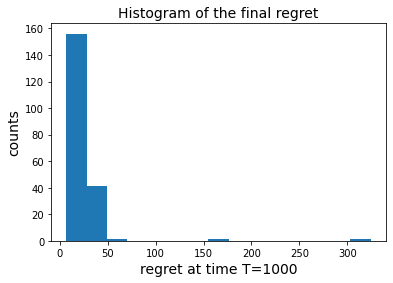

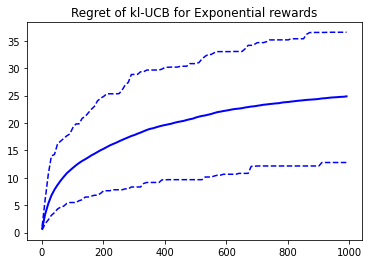

In [30]:
banditExpo = MAB([arm.Exponential(1), arm.Exponential(2), arm.Exponential(3)])
learnerExpo = klUCB(3, klucbExp)

timeHorizon = 1000
nExp = 200
tsave = np.arange(1, timeHorizon, 10)

Regret = OneBanditOneLearnerMultipleRuns(banditExpo, learnerExpo, timeHorizon, nExp, tsave)

FinalRegret = Regret[:, len(tsave)-1]
plt.xlabel("regret at time T="+str(timeHorizon), fontsize=14)
plt.ylabel("counts", fontsize=14)
plt.hist(FinalRegret, 15)
plt.title("Histogram of the final regret", fontsize=14)

plt.figure()
plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color="b")
plt.plot(tsave, np.quantile(Regret, 0.95, 0), tsave, np.quantile(Regret, 0.05, 0), linestyle="dashed", color="b")
plt.title("Regret of kl-UCB for Exponential rewards")

# VI) A Bayesian strategy: Thompson Sampling 

We now explore one of the Bayesian strategies discussed in class: **Thompson Sampling**. This heuristic is very old, and its theoretical understanding is still quite partial beyond simple settings. Still, in the Bernoulli case, it is proved to be asymptotically optimal. Letting $\pi_a(t)$ denote the posterior distribution on arm $a$ after $t$ rounds, the algorithm can be implemented as follows: 

$$\forall a, \theta_a(t) \sim \pi_a(t-1), \ \ \ A_{t} = \underset{a}{\text{argmax }} \theta_a(t)$$

In the Bernoulli case, with a uniform (or more generally a Beta$(\alpha,\beta)$) prior distribution on each mean, the posterior distribution remains a Beta distribution. More precisely, one has

$$\pi_a(t) = \mathrm{Beta}\left(\alpha + S_a(t), \beta + N_a(t) - S_a(t)\right),$$

where $S_a(t)$ is the sum of rewards received from arm $a$ after $t$ rounds, and $N_a(t)$ is the number of selections of that arm, as before.

* Implement Thompson Sampling for binary bandits with a Beta prior. 



In [31]:
class ThompsonSampling:
    """Thompson Sampling with Beta(a,b) prior and Bernoulli likelihood"""
    def __init__(self, nbArms, a=1, b=1):
        self.nbArms = nbArms
        self.a = a
        self.b = b
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
    
    def chooseArmToPlay(self):
        posterior_samples = np.zeros(self.nbArms)
        for a in range(self.nbArms):
            posterior_samples[a]= np.random.beta(self.cumRewards[a]+self.a, self.nbDraws[a]-self.cumRewards[a]+self.b)
        return randmax(posterior_samples)

    def receiveReward(self, arm, reward):
        # binarization trick if the rewards are bounded in [0,1]
        binreward = float(np.random.random()<reward)
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + binreward

    def name(self):
        return "Thompson Sampling"

* Compare this algorithm to UCB and kl-UCB on a binary instance of your choice.

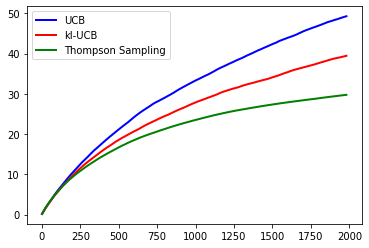

In [32]:
means = [0.1, 0.15, 0.2, 0.25]

bandit = BernoulliBandit(means)
K = len(means)

nExp = 200
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)

algos = [UCB(K), klUCB(K), ThompsonSampling(K)]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())

plt.legend()


#### kl-UCB and Thompson Sampling for bounded rewards

kl-UCB and Thompson Sampling can both be used for any bandit instance with rewards that are bounded in $[0,1]$. kl-UCB can be used without any modification (its analysis just extends to bounded distribution, as the sample concentration inequality can be used). However, for Thompson Sampling it is not the case: the algorithm needs to be modified to handle possibly non-binary rewards. The "binarization trick" that can be employed is described [here](http://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf).

* Check that your implementation of Thompson Sampling incorporates this binarization trick, and run the 3 previous algorithms on a bandit instance with bounded rewards that are not only binary. 

arm means are
[0.36716600055044046, 0.3167376438773787, 0.27708646187933755]


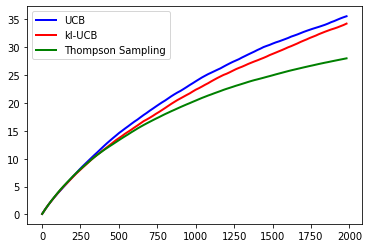

In [33]:
bandit = MAB([arm.TruncatedExponential(2.5, 1), arm.TruncatedExponential(3, 1), arm.TruncatedExponential(3.5, 1)])
print("arm means are")
print(bandit.means)
K = len(bandit.means)

nExp = 200
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)

algos = [UCB(K), klUCB(K), ThompsonSampling(K)]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())

plt.legend()

# VII) Trying other bandit strategies 

You are welcome to try other approaches from the (rich) multi-armed bandit literature. 

* If you are interested in further understanding some randomized algorithm, you can try BESA, a puzzling strategy based on sub sampling: https://hal.archives-ouvertes.fr/file/index/docid/1025651/filename/BESA2.pdf

* We did not (yet) talk about adversarial bandit approaches, for you may want to add the EXP3 strategy to this comparison at some point: http://rob.schapire.net/papers/AuerCeFrSc01.pdf

* Or maybe a recent paper who tries to propose an algorithm efficient for stochastic and adversarial bandits: 
https://arxiv.org/abs/1807.07623